In [1]:
import uproot as uproot

import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
root_file = uproot.open('data/0001_64k_real_spectra_15x15_spot.root')
nevents=None

# Наблюдаемые величины
RawE = root_file['ecalNT']['RawEnergyDeposit'].arrays(library='np')['RawEnergyDeposit'][:nevents]
x = root_file['ecalNT']['RawX'].arrays(library='np')['RawX'][:nevents]
y = root_file['ecalNT']['RawY'].arrays(library='np')['RawY'][:nevents]
z = root_file['ecalNT']['RawZ'].arrays(library='np')['RawZ'][:nevents]
EnergyDeposit = [img.reshape(15,15)[None,:,:] for img in np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])]

# Величины на входе симулятора
ParticlePDG = np.array(root_file['ecalNT']['ParticlePDG'].array())[:nevents]
ParticleMomentum_v = np.array(root_file['ecalNT']['ParticleMomentum'].array())[:nevents]
ParticleMomentum = np.sum(ParticleMomentum_v * ParticleMomentum_v, axis=1) ** 0.5

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [4]:
X = np.array(EnergyDeposit).reshape(len(EnergyDeposit), -1)
y = ParticleMomentum

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


train_generator = torch.Generator()
train_generator.manual_seed(0)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0, worker_init_fn=seed_worker, generator=train_generator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

In [5]:
class MyModel(nn.Module):
    def __init__(self, height=15, width=15) -> None:
        super(MyModel, self).__init__()

        self.height = height
        self.width = width

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1),
            # nn.BatchNorm2d(2),
            nn.GELU(),
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1),
            # nn.BatchNorm2d(4),
            nn.GELU(),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            # nn.BatchNorm2d(8),
            nn.GELU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            # nn.BatchNorm2d(16),
            nn.GELU(),
            # nn.Dropout(0.5)
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(16, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.height, self.width)
        x = self.conv(x)
        x = self.adaptive_pool(x)  # (batch_size, 16, 1, 1)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.flatten()
        return x

In [6]:
def train_fn(train_loader, val_loader, model, optimizer, lr_scheduler, criterion, num_epochs, device, log_freq=100):

    train_loss = []
    train_batch_idx = []
    train_num_batches = 0

    val_loss = []

    for epoch in range(1, num_epochs + 1):
        epoch_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        num_batches = 0
        model.train()
        for data, trg in train_loader:
            train_num_batches += 1
            num_batches += 1
            optimizer.zero_grad()

            data = data.to(device)
            trg = trg.to(device)

            output = model(data)
            # loss = (torch.sqrt(criterion(output, trg)) / trg).mean()
            loss = criterion(output, trg, 1 / trg)
            epoch_loss += loss.detach()
            loss.backward()
            optimizer.step()

            if train_num_batches % log_freq == 0:
                train_batch_idx.append(train_num_batches)
                train_loss.append(loss.item())
                clear_output(True)

                plt.figure(figsize=(15, 7))

                plt.subplot(1, 2, 1)
                plt.plot(train_batch_idx, train_loss)
                plt.xlabel("Batch index")
                plt.ylabel("RMSE / Momentum")
                plt.grid()
                plt.title("Train loss")

                plt.subplot(1, 2, 2)
                plt.plot(list(range(1, epoch)), val_loss)
                plt.xlabel("Epoch")
                plt.ylabel("RMSE / Momentum")
                plt.grid()
                plt.title("Validation loss")

                plt.show()
                print(f"Epoch: {epoch}/{num_epochs} || Batch: {num_batches}/{len(train_loader)} || Train loss: {epoch_loss / num_batches} || Val loss: {(val_loss[-1] if val_loss else -1.0):0.4f}")
        
        cur_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            for data, trg in val_loader:
                data = data.to(device)
                trg = trg.to(device)

                output = model(data)
                 #cur_loss += (torch.sqrt(criterion(output, trg)) / trg).mean().detach()
                cur_loss += criterion(output, trg, 1 / trg).detach()
        
        val_loss.append((cur_loss / len(val_loader)).item())

        lr_scheduler.step()
    
    return train_loss, train_batch_idx

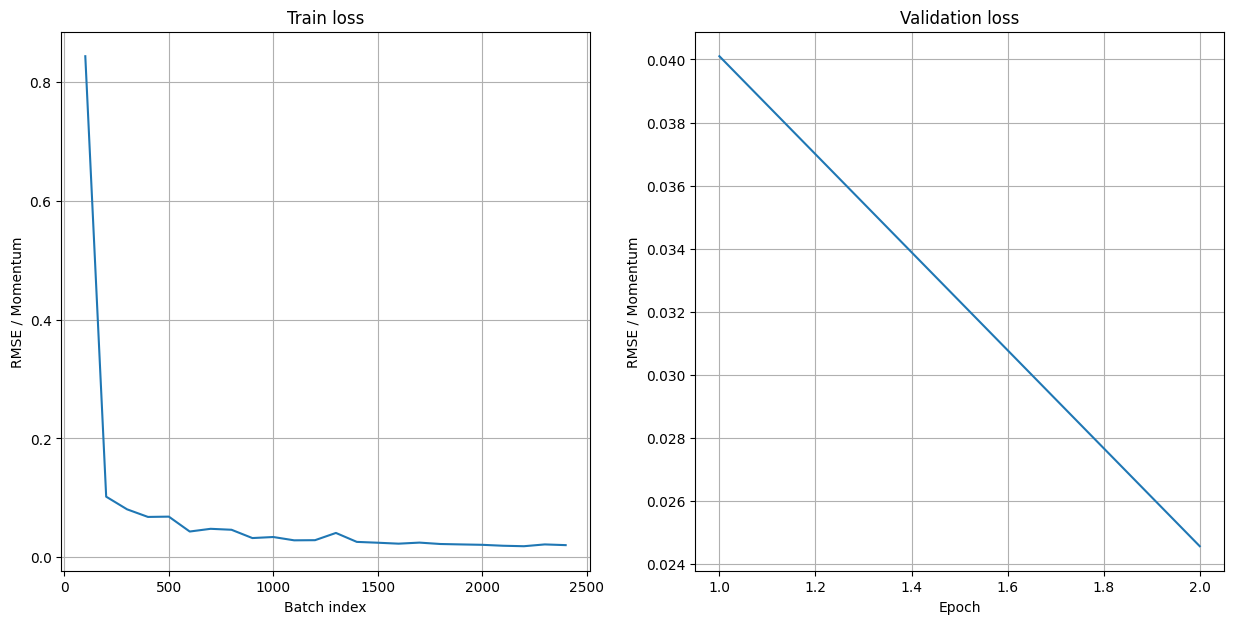

Epoch: 3/3 || Batch: 798/801 || Train loss: tensor([0.0212], device='cuda:0') || Val loss: 0.0246


In [7]:
def loss_fn(pred, trg, weights):
    return (torch.sqrt(F.mse_loss(pred, trg, reduction='none')) * weights).mean()

model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)
criterion = loss_fn
num_epochs = 3

train_loss, train_batch_idx = train_fn(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device
)

In [8]:
model(torch.tensor(X_train[0][None, ...], dtype=torch.float32, device=device))

tensor([54.5645], device='cuda:0', grad_fn=<ViewBackward0>)

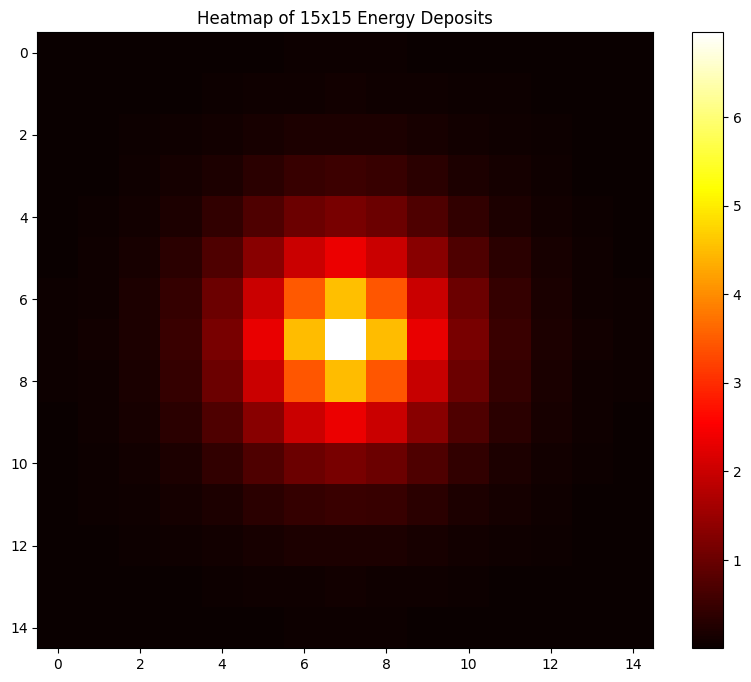

In [9]:
plt.figure(figsize=(10, 8))
plt.imshow(np.mean(np.log1p(X_train), axis=0).reshape(15, 15), cmap='hot', interpolation='nearest')
plt.title("Heatmap of 15x15 Energy Deposits")
plt.colorbar()
plt.show()

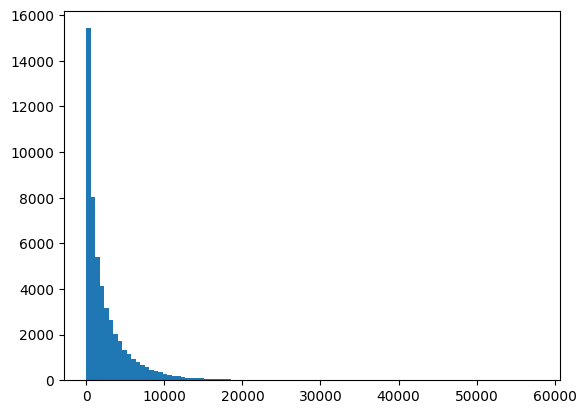

In [23]:
plt.hist(X_train[:, 112], bins=100, )

plt.show()

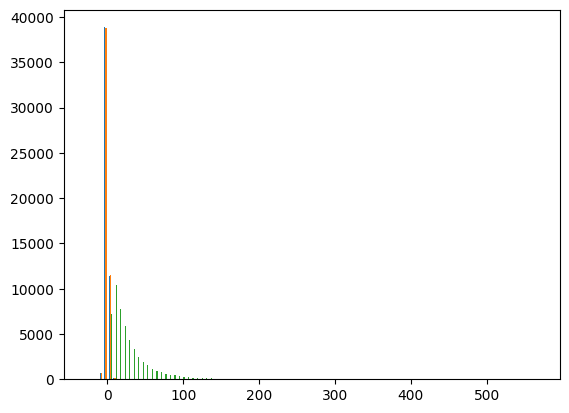

In [50]:
plt.hist(y_train, bins=100)

plt.show()